# RECONHECIMENTO DE SENTIMENTOS

Dataset: https://www.kaggle.com/datasets/ejlok1/toronto-emotional-speech-set-tess ( Toronto emotional speech set (TESS) - Um conjunto de dados para classificação de emoção de treinamento (7 emoções cardeais) em áudio )

Código base: https://www.kaggle.com/code/verreljuantolukmana/emotional-speech-recognition-audio-process-all

# PACOTES E BIBLIOTECAS

In [1]:
#!pip install pydub
#!pip install librosa
#!pip install keras
#!pip install tensorflow
#!pip install np_utils

In [16]:
#GENERAL
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
#PATH PROCESS
import os
import os.path
from pathlib import Path
import glob
#MUSIC PROCESS
import pydub
from scipy.io.wavfile import read, write
import librosa
import librosa.display
import IPython
from IPython.display import Audio
import scipy
#SCALER & TRANSFORMATION
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import regularizers
from sklearn.preprocessing import LabelEncoder
#ACCURACY CONTROL
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
#OPTIMIZER
from keras.optimizers import RMSprop,Adam,Optimizer,Optimizer, SGD
#MODEL LAYERS
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D,BatchNormalization,\
                        Permute, TimeDistributed, Bidirectional,GRU, SimpleRNN,\
LSTM, GlobalAveragePooling2D, SeparableConv2D, ZeroPadding2D, Convolution2D, ZeroPadding2D,Reshape,\
Conv2DTranspose, LeakyReLU, Conv1D, AveragePooling1D, MaxPooling1D
from keras import models
from keras import layers
import tensorflow as tf
from keras.applications import VGG16,VGG19,inception_v3
from keras import backend as K
from keras.utils import plot_model
from keras.datasets import mnist
import keras
import IPython.display as ipd

# CAMINHO, RÓTULO, TRANSFORMAÇÃO

Aqui é criado um objetivo do tipo "Path" que representa o diretório do dataset.

In [21]:
Main_WAV_Path = Path("TESS Toronto emotional speech set data")

A função "glob" é usada para listar todos os arquivos com a extensão .wav

In [22]:
Wav_Path = list(Main_WAV_Path.glob(r"**/*.wav"))

Aqui são identificadas as classes do dataset através das pastas nas quais os arquivos estão salvos.

In [23]:
#print(Wav_Path[0])
#os.path.split(os.path.split(Wav_Path[0])[0])[1]

Wav_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],Wav_Path))

#Wav_Labels

Transformação dos dados em séries da biblioteca Pandas.

In [24]:
Wav_Path_Series = pd.Series(Wav_Path,name="WAV").astype(str)
Wav_Labels_Series = pd.Series(Wav_Labels,name="EMOTION")

print(Wav_Labels_Series.head(-1))

0       OAF_angry
1       OAF_angry
2       OAF_angry
3       OAF_angry
4       OAF_angry
          ...    
5594      YAF_sad
5595      YAF_sad
5596      YAF_sad
5597      YAF_sad
5598      YAF_sad
Name: EMOTION, Length: 5599, dtype: object


In [25]:
Main_Wav_Data = pd.concat([Wav_Path_Series,Wav_Labels_Series],axis=1)

In [26]:
#print(Main_Wav_Data.head(-1))
Main_Wav_Data.head()

,WAV,EMOTION
0,TESS Toronto emotional speech set data\OAF_ang...,OAF_angry
1,TESS Toronto emotional speech set data\OAF_ang...,OAF_angry
2,TESS Toronto emotional speech set data\OAF_ang...,OAF_angry
3,TESS Toronto emotional speech set data\OAF_ang...,OAF_angry
4,TESS Toronto emotional speech set data\OAF_ang...,OAF_angry


Contagem de exemplares de cada classe do dataset.

In [27]:
print(Main_Wav_Data["EMOTION"].value_counts())

OAF_angry                 400
OAF_disgust               400
OAF_Fear                  400
OAF_happy                 400
OAF_neutral               400
OAF_Pleasant_surprise     400
OAF_Sad                   400
YAF_angry                 400
YAF_disgust               400
YAF_fear                  400
YAF_happy                 400
YAF_neutral               400
YAF_pleasant_surprised    400
YAF_sad                   400
Name: EMOTION, dtype: int64


Dataset é embaralhado em seguida.

In [28]:
Main_Wav_Data = Main_Wav_Data.sample(frac=1).reset_index(drop=True)
Main_Wav_Data.head()

,WAV,EMOTION
0,TESS Toronto emotional speech set data\OAF_neu...,OAF_neutral
1,TESS Toronto emotional speech set data\TESS To...,OAF_angry
2,TESS Toronto emotional speech set data\TESS To...,OAF_neutral
3,TESS Toronto emotional speech set data\TESS To...,YAF_sad
4,TESS Toronto emotional speech set data\YAF_fea...,YAF_fear


# EXEMPLO DE ÁUDIO

In [29]:
x, sr = librosa.load(Main_Wav_Data['WAV'][0])  # Obs: o Librosa por padrão converte o áudio para a amostragem de 22050 Hz
print(sr)
ipd.Audio(x, rate=sr)

22050


In [30]:
print("Emoção associada ao áudio acima: " + Main_Wav_Data['EMOTION'][0])

Emoção associada ao áudio acima: OAF_neutral


Forma de onda deste exemplar

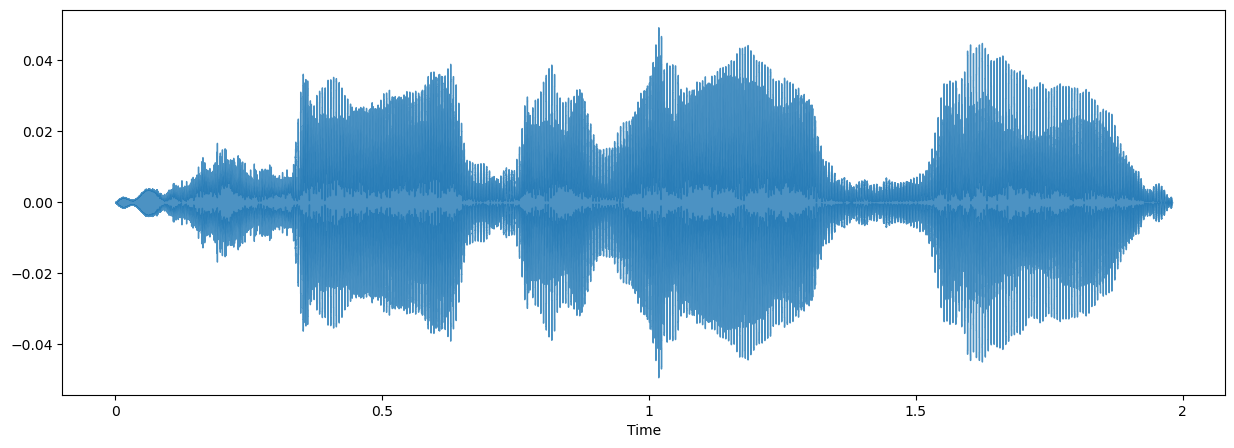

In [31]:
plt.figure(figsize=(15, 5))
librosa.display.waveshow(x, sr=sr, alpha=0.8)

# FUNÇÕES DE PROCESSAMENTO DE DADOS

Aqui são criadas algumas funções de processamento do áudio: adicionar ruído, "esticar" o áudio, shift e mudança de tom. Dessa forma, é feito um "data augmentation".

In [32]:
def add_noise(data):
    noise_value = 0.015 * np.random.uniform() * np.amax(data)
    data = data + noise_value * np.random.normal(size=data.shape[0])
    return data

def stretch_process(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=0.8)

def shift_process(data):
    shift_range = int(np.random.uniform(low=-5,high=5) * 1000)
    return np.roll(data,shift_range)

def pitch_process(data,sampling_rate,pitch_factor=0.7):
    return librosa.effects.pitch_shift(data,sr=22050,n_steps=4)

Função de extração de características dos áudios.

In [33]:
def extract_process(data,sample_rate=22050):

    output_result = np.array([])
    mean_zero = np.mean(librosa.feature.zero_crossing_rate(y=data).T,axis=0)
    output_result = np.hstack((output_result,mean_zero))

    stft_out = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft_out,sr=sample_rate).T,axis=0)
    output_result = np.hstack((output_result,chroma_stft))

    mfcc_out = np.mean(librosa.feature.mfcc(y=data,sr=sample_rate).T,axis=0)
    output_result = np.hstack((output_result,mfcc_out))

    root_mean_out = np.mean(librosa.feature.rms(y=data).T,axis=0)
    output_result = np.hstack((output_result,root_mean_out))

    mel_spectogram = np.mean(librosa.feature.melspectrogram(y=data,sr=sample_rate).T,axis=0)
    output_result = np.hstack((output_result,mel_spectogram))

    return output_result

Esta função cria um array NumPy com as características extraídas do áudio original e suas versões processadas.

In [34]:
def export_process(path):

    data,sample_rate = librosa.load(path,duration=2.5,offset=0.6)

    output_1 = extract_process(data)
    result = np.array(output_1)

    noise_out = add_noise(data)
    output_2 = extract_process(noise_out)
    result = np.vstack((result,output_2))

    new_out = stretch_process(data)
    strectch_pitch = pitch_process(new_out,sample_rate)
    output_3 = extract_process(strectch_pitch)
    result = np.vstack((result,output_3))

    return result

# ANÁLISE

Aqui (usando uma forma diferente) são mostrados alguns exemplos de áudio.

In [35]:
rate,speech = read(Main_Wav_Data["WAV"][2342])
print(Main_Wav_Data["EMOTION"][2342])

Audio(speech,rate=rate,autoplay=False)

YAF_neutral


In [36]:
rate,speech = read(Main_Wav_Data["WAV"][3])
print(Main_Wav_Data["EMOTION"][3])

Audio(speech,rate=rate,autoplay=False)

YAF_sad


In [37]:
rate,speech = read(Main_Wav_Data["WAV"][2795])
print(Main_Wav_Data["EMOTION"][2795])

Audio(speech,rate=rate,autoplay=False)

OAF_neutral


Para que seja possível visualizar o espectro (representação no domínio da frequência) de um exemplar de áudio, é aplicada a Transformada de Fourier de Tempo Curto (STFT). Depois, a amplitude do espectograma é convertida para a escala de decibéis (dB).

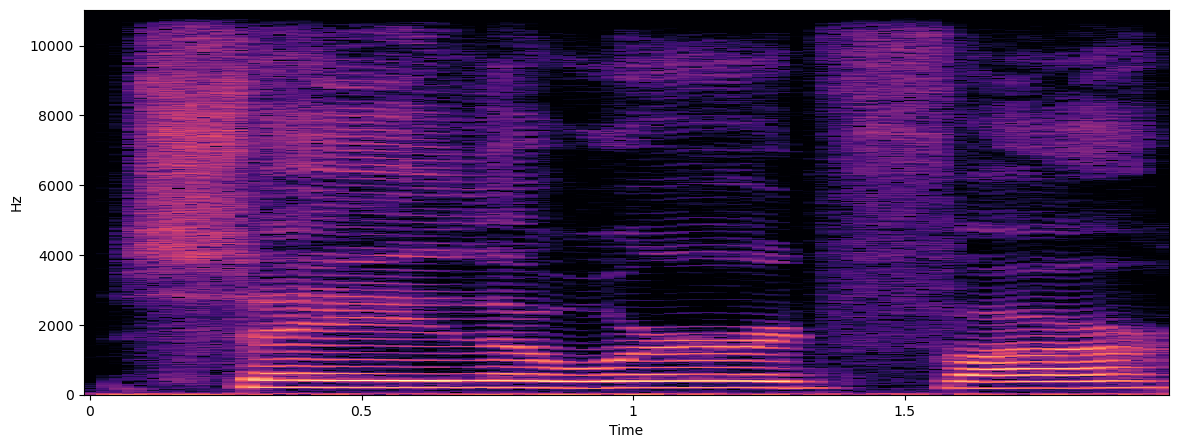

In [38]:
figure = plt.figure(figsize=(14,5))

audio_speech,rate = librosa.load(Main_Wav_Data["WAV"][2795])

stft_audio = librosa.stft(audio_speech)
Db_audio = librosa.amplitude_to_db(abs(stft_audio))
librosa.display.specshow(Db_audio,sr=rate,x_axis="time",y_axis="hz")
Audio(audio_speech,rate=rate)

# PROCESSAMENTO DE DADOS

Agora os arquivos serão de fato processados com as funções criadas anteriormente.

In [39]:
from tqdm import tqdm # Biblioteca para criar barra de progresso

total_iterations = len(Main_Wav_Data.WAV)
x_Train, y_Train = [], []

# Obtendo o número total de iterações (total de arquivos de áudio)
total_files = len(Main_Wav_Data)
print("Total de arquivos: " + str(total_files))

Total de arquivos: 5600


In [40]:
for path, emotion in tqdm(zip(Main_Wav_Data.WAV, Main_Wav_Data.EMOTION), total=total_files, desc="Processando", ascii=True, ncols=100):
    # Realização do processamento e extração de recursos usando a função export_process()
    features = export_process(path)

    for element in features:
        x_Train.append(element)
        y_Train.append(emotion)

# O loop foi concluído
print(" - Concluído!")


Processando: 100%|##############################################| 5600/5600 [08:50<00:00, 10.56it/s]

 - Concluído!


In [42]:
print(len(x_Train))
print(len(y_Train))
print(len(Main_Wav_Data.WAV))

16800
16800
5600


In [43]:
print(x_Train[0].shape)

(162,)


Até o momento, cada faixa de áudio (incluindo as versões obtidas por "data augmentation") foi precessada e convertida em um vetor de características, com "shape" (162,). Agora é feita a união dos dados de cada áudio com o rótulo correspondente.

In [44]:
New_Features_Wav = pd.DataFrame(x_Train)
New_Features_Wav["EMOTIONS"] = y_Train

New_Features_Wav.to_csv("New_Wav_Set.csv",index=False)

In [45]:
New_Features_Wav.head(-1)

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,EMOTIONS
0,0.035498,0.122806,0.220999,0.274604,0.149037,0.158583,0.301753,0.650884,0.849546,0.429842,...,0.000008,0.000016,0.000032,0.000027,0.000019,0.000011,0.000009,0.000005,5.139809e-07,OAF_neutral
1,0.046940,0.180283,0.280668,0.332581,0.210672,0.224466,0.355122,0.670532,0.861418,0.454081,...,0.000031,0.000043,0.000058,0.000049,0.000044,0.000034,0.000032,0.000027,2.493092e-05,OAF_neutral
2,0.058053,0.197200,0.146297,0.152776,0.112635,0.196252,0.319273,0.143839,0.146089,0.337088,...,0.000001,0.000004,0.000005,0.000002,0.000002,0.000002,0.000002,0.000002,2.159881e-07,OAF_neutral
3,0.110921,0.500031,0.510844,0.495451,0.520781,0.512602,0.399947,0.369054,0.454470,0.386907,...,0.000491,0.001029,0.000924,0.000478,0.000606,0.000976,0.001263,0.000593,4.622728e-05,OAF_angry
4,0.200149,0.663434,0.655717,0.595427,0.588512,0.636603,0.524022,0.424869,0.522329,0.508203,...,0.001913,0.002464,0.002447,0.001941,0.002109,0.002347,0.002643,0.002108,1.526986e-03,OAF_angry
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16794,0.052121,0.307155,0.404344,0.710487,0.635737,0.430379,0.279927,0.263536,0.268355,0.307465,...,0.000064,0.000064,0.000072,0.000158,0.000124,0.000106,0.000042,0.000021,1.436722e-06,OAF_Fear
16795,0.095908,0.359138,0.454433,0.764301,0.702392,0.510118,0.336341,0.290677,0.319837,0.350574,...,0.000100,0.000106,0.000109,0.000195,0.000157,0.000140,0.000074,0.000057,3.487246e-05,OAF_Fear
16796,0.060737,0.285348,0.361611,0.417486,0.304277,0.261144,0.393664,0.738657,0.604075,0.377134,...,0.000028,0.000026,0.000046,0.000106,0.000124,0.000039,0.000073,0.000047,3.436461e-06,OAF_Fear
16797,0.180062,0.496480,0.451650,0.404051,0.495442,0.622913,0.489968,0.454688,0.481092,0.460427,...,0.011861,0.009750,0.005631,0.002593,0.002100,0.001789,0.002284,0.001875,1.993036e-04,YAF_angry


A contagem mostrada abaixo mostra que o dataset se encontra balanceado.

In [46]:
print(New_Features_Wav["EMOTIONS"].value_counts())

OAF_neutral               1200
OAF_angry                 1200
YAF_sad                   1200
YAF_fear                  1200
YAF_neutral               1200
YAF_happy                 1200
OAF_disgust               1200
YAF_angry                 1200
OAF_Pleasant_surprise     1200
OAF_Fear                  1200
YAF_pleasant_surprised    1200
OAF_Sad                   1200
OAF_happy                 1200
YAF_disgust               1200
Name: EMOTIONS, dtype: int64


In [47]:
encoder_label = OneHotEncoder()

In [48]:
scaler_data = StandardScaler()

In [49]:
X = New_Features_Wav.iloc[:,:-1].values
Y = New_Features_Wav["EMOTIONS"].values

In [50]:
print(X.shape)
print(Y.shape)

(16800, 162)
(16800,)


In [51]:
Y = encoder_label.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [52]:
print(Y.shape) # Observe que são 14 classes

(16800, 14)


In [53]:
xTrain,xTest,yTrain,yTest = train_test_split(X,Y,train_size=0.9,random_state=42,shuffle=True)

In [54]:
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(15120, 162)
(15120, 14)
(1680, 162)
(1680, 14)


In [55]:
xTrain = scaler_data.fit_transform(xTrain)
xTest = scaler_data.transform(xTest)

In [56]:
print(xTrain.shape)
print(xTest.shape)

(15120, 162)
(1680, 162)


In [57]:
xTrain = np.expand_dims(xTrain,axis=2)
xTest = np.expand_dims(xTest,axis=2)

In [58]:
print(xTrain.shape)
print(xTest.shape)

(15120, 162, 1)
(1680, 162, 1)


# ESTRUTURA DO MODELO E TREINAMENTO

In [2]:
Model=Sequential([
    layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(xTrain.shape[1], 1)),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Conv1D(32, kernel_size=5, strides=1, padding='same', activation='relu'),
    layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(units=32, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(units=14, activation='softmax')
])

NameError: name 'Sequential' is not defined

In [3]:
Model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

NameError: name 'Model' is not defined

In [61]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")

In [63]:
Conv1D_Model = Model.fit(xTrain, yTrain, batch_size=64, epochs=50, validation_data=(xTest, yTest), callbacks=[early_stop])

Epoch 1/50
237/237 [==============================] - 14s 59ms/step - loss: 0.2430 - accuracy: 0.9201 - val_loss: 0.0772 - val_accuracy: 0.9732
Epoch 2/50
237/237 [==============================] - 14s 58ms/step - loss: 0.1897 - accuracy: 0.9386 - val_loss: 0.1191 - val_accuracy: 0.9589
Epoch 3/50
237/237 [==============================] - 14s 58ms/step - loss: 0.1509 - accuracy: 0.9512 - val_loss: 0.0606 - val_accuracy: 0.9768
Epoch 4/50
237/237 [==============================] - 14s 58ms/step - loss: 0.1351 - accuracy: 0.9568 - val_loss: 0.0586 - val_accuracy: 0.9768
Epoch 5/50
237/237 [==============================] - 14s 57ms/step - loss: 0.1086 - accuracy: 0.9660 - val_loss: 0.0454 - val_accuracy: 0.9851
Epoch 6/50
237/237 [==============================] - 15s 62ms/step - loss: 0.0923 - accuracy: 0.9704 - val_loss: 0.0408 - val_accuracy: 0.9869
Epoch 7/50
237/237 [==============================] - 14s 58ms/step - loss: 0.0921 - accuracy: 0.9723 - val_loss: 0.0655 - val_accuracy:

<Axes: >

<Figure size 1000x1000 with 0 Axes>

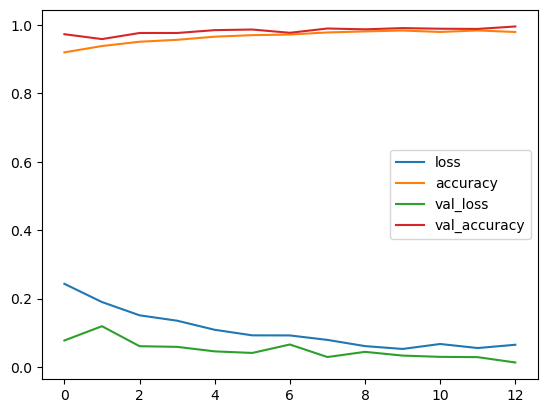

In [64]:
Grap_Data = pd.DataFrame(Conv1D_Model.history)
figure = plt.figure(figsize=(10,10))
Grap_Data.plot()

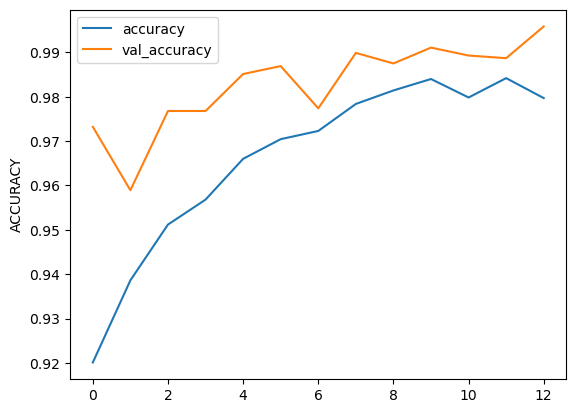

In [65]:
plt.plot(Conv1D_Model.history["accuracy"])
plt.plot(Conv1D_Model.history["val_accuracy"])
plt.ylabel("ACCURACY")
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

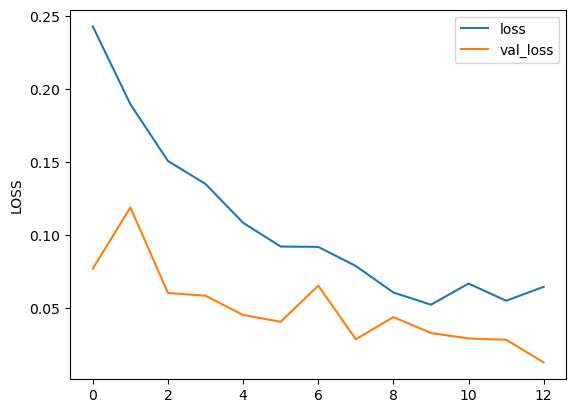

In [66]:
plt.plot(Conv1D_Model.history["loss"])
plt.plot(Conv1D_Model.history["val_loss"])
plt.ylabel("LOSS")
plt.legend(['loss', 'val_loss'])
plt.show()

# PREDIÇÃO

In [67]:
Model_Results = Model.evaluate(xTest,yTest)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.4f" % Model_Results[1])

53/53 [==============================] - 1s 12ms/step - loss: 0.0129 - accuracy: 0.9958
LOSS:  0.0129
ACCURACY:  0.9958


In [68]:
prediction_test = Model.predict(xTest)
y_prediction = encoder_label.inverse_transform(prediction_test)

yTest = encoder_label.inverse_transform(yTest)

53/53 [==============================] - 1s 10ms/step


In [69]:
print(prediction_test[0:10])

[[1.79353375e-12 5.41117988e-05 6.03072340e-06 4.52974405e-08
  9.99938726e-01 7.76108266e-07 2.56404685e-12 3.96612403e-13
  1.10602116e-07 3.17452011e-12 2.87711787e-15 4.61813754e-10
  2.39171599e-11 5.98927201e-08]
 [3.18346800e-21 3.46312978e-14 2.58334222e-25 9.23533385e-13
  4.06899308e-17 1.99526740e-20 1.70406095e-19 1.00000000e+00
  1.35439771e-10 5.97961296e-13 4.44982717e-10 2.11507705e-13
  4.27834905e-08 4.75261992e-24]
 [2.31467534e-34 2.16983265e-16 5.39828963e-35 6.12585203e-25
  3.40880613e-19 2.10781372e-30 1.34859404e-34 1.87930211e-13
  1.00000000e+00 1.34746403e-32 1.45717027e-28 6.76859975e-19
  4.81378826e-10 1.64724845e-32]
 [6.19965516e-37 0.00000000e+00 0.00000000e+00 1.21027734e-22
  0.00000000e+00 3.75345910e-37 0.00000000e+00 2.08847764e-14
  0.00000000e+00 1.45734889e-12 1.00000000e+00 9.27468620e-27
  1.42542369e-23 5.84038491e-31]
 [4.43890674e-10 1.15141724e-04 5.75613340e-05 9.57245788e-07
  9.99801219e-01 2.35542279e-06 3.18832316e-09 2.22549298e-10


In [70]:
print(y_prediction[0:10])

[['OAF_disgust']
 ['YAF_angry']
 ['YAF_disgust']
 ['YAF_happy']
 ['OAF_disgust']
 ['YAF_sad']
 ['YAF_fear']
 ['OAF_Sad']
 ['YAF_disgust']
 ['YAF_fear']]


In [71]:
print(yTest[0:10])

[['OAF_disgust']
 ['YAF_angry']
 ['YAF_disgust']
 ['YAF_happy']
 ['OAF_disgust']
 ['YAF_sad']
 ['YAF_fear']
 ['OAF_Sad']
 ['YAF_disgust']
 ['YAF_fear']]


In [72]:
conf_matrix = confusion_matrix(yTest, y_prediction)

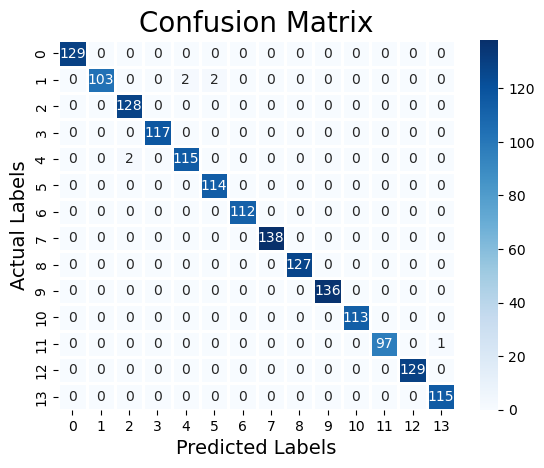

In [73]:
sns.heatmap(conf_matrix, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')

plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [74]:
print(classification_report(yTest, y_prediction))

                        precision    recall  f1-score   support

              OAF_Fear       1.00      1.00      1.00       129
 OAF_Pleasant_surprise       1.00      0.96      0.98       107
               OAF_Sad       0.98      1.00      0.99       128
             OAF_angry       1.00      1.00      1.00       117
           OAF_disgust       0.98      0.98      0.98       117
             OAF_happy       0.98      1.00      0.99       114
           OAF_neutral       1.00      1.00      1.00       112
             YAF_angry       1.00      1.00      1.00       138
           YAF_disgust       1.00      1.00      1.00       127
              YAF_fear       1.00      1.00      1.00       136
             YAF_happy       1.00      1.00      1.00       113
           YAF_neutral       1.00      0.99      0.99        98
YAF_pleasant_surprised       1.00      1.00      1.00       129
               YAF_sad       0.99      1.00      1.00       115

              accuracy                

In [75]:
print(accuracy_score(yTest, y_prediction))

0.9958333333333333
